# Kirkwood-Buff example: NaCl in water

In this example we calculate Kirkwood-Buff integrals in a solute (c) and solvent (w) system and correct for finite size effects as described at http://dx.doi.org/10.1073/pnas.0902904106 (see Supporting Information).

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md
from math import pi
from scipy import integrate
plt.rcParams.update({'font.size': 16})

### Load gromacs trajectory/topology

Gromacs was used to sample a dilute solution of sodium chloride in SPC/E water for 100 ns.
The trajectory and `.gro` loaded below have been stripped from hydrogens to reduce disk space.

In [2]:
traj = md.load('gmx/traj_noh.xtc', top='gmx/conf_noh.gro')
traj

<mdtraj.Trajectory with 50001 frames, 999 atoms, 999 residues, and unitcells at 0x105829790>

### Calculate average number densities for solute and solvent

Simulation time            =  100.0 ns
Average volume             =  29.6724630365 nm-3
Average side-length        =  3.09588295076 nm
Number of solute molecules =  36
Number of water molecules  =  963
Solute density             =  1.2132460981 nm-3
Water density              =  32.4543331241 nm-3


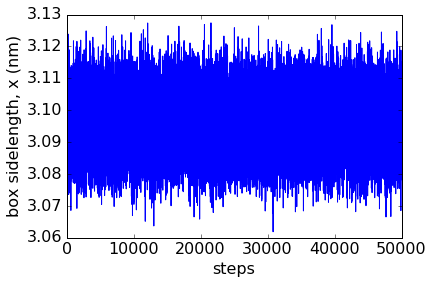

In [3]:
volume=0
for vec in traj.unitcell_lengths: 
  volume = volume + vec[0]*vec[1]*vec[2] / traj.n_frames
N_c   = len(traj.topology.select('name NA or name CL'))
N_w   = len(traj.topology.select('name O'))
rho_c = N_c / volume
rho_w = N_w / volume
print "Simulation time            = ", traj.time[-1]*1e-3, 'ns'
print "Average volume             = ", volume, 'nm-3'
print "Average side-length        = ", volume**(1/3.), 'nm'
print "Number of solute molecules = ", N_c
print "Number of water molecules  = ", N_w
print "Solute density             = ", rho_c, 'nm-3'
print "Water density              = ", rho_w, 'nm-3'

steps=range(traj.n_frames)
plt.xlabel('steps')
plt.ylabel('box sidelength, x (nm)')
plt.plot(traj.unitcell_lengths[:,0])

### Compute and plot RDFs
_Note:_ The radial distribution function in `mdtraj` differs from _i.e._ Gromacs `g_rdf` in
the way data is normalized and the $g(r)$ may need rescaling. It seems that densities
are calculated by the number of selected pairs which for the `cc` case exclude all the
self terms. This can be easily corrected and is obviously not needed for the `wc` case.

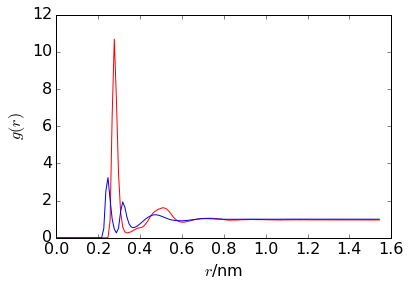

In [4]:
rmax = (volume)**(1/3.)/2
select_cc = traj.topology.select_pairs('name NA or name CL', 'name NA or name CL')
select_wc = traj.topology.select_pairs('name NA or name CL', 'name O')
r, g_cc = md.compute_rdf(traj, select_cc, r_range=[0.0,rmax], bin_width=0.01, periodic=True)
r, g_wc = md.compute_rdf(traj, select_wc, r_range=[0.0,rmax], bin_width=0.01, periodic=True)
g_cc = g_cc * len(select_cc) / (0.5*N_c**2) # re-scale to account for diagonal in pair matrix

np.savetxt('g_cc.dat', np.column_stack( (r,g_cc) ))
np.savetxt('g_wc.dat', np.column_stack( (r,g_wc) ))

plt.xlabel('$r$/nm')
plt.ylabel('$g(r)$')
plt.plot(r, g_cc, 'r-')
plt.plot(r, g_wc, 'b-')

### Calculate KB integrals
Here we calculate the number of solute molecules around other solute molecules (cc) and around water (wc).
For example,

$$ N_{cc} = 4\pi\rho_c\int_0^{\infty} \left ( g(r)_{cc} -1 \right ) r^2 dr$$

The preferential binding parameter is subsequently calculated as $\Gamma =  N_{cc}-N_{wc}$.

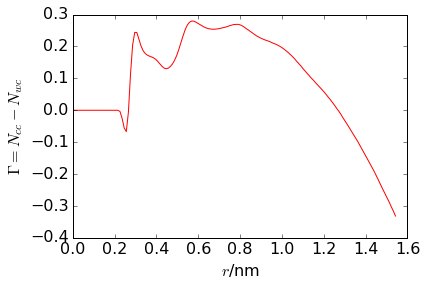

In [5]:
dr    = r[1]-r[0]
N_cc  = rho_c * 4*pi*np.cumsum( ( g_cc - 1 )*r**2*dr )
N_wc  = rho_c * 4*pi*np.cumsum( ( g_wc - 1 )*r**2*dr )
Gamma = N_cc - N_wc
plt.xlabel('$r$/nm')
plt.ylabel('$\\Gamma = N_{cc}-N_{wc}$')
plt.plot(r, Gamma, 'r-')

### Finite system size corrected KB integrals
As can be seen in the above figure, the KB integrals do not converge since in a finite sized $NVT$ simulation,
$g(r)$ can never exactly go to unity at large separations.
To correct for this, a simple scaling factor can be applied, as describe in the link on top of the page,

$$ g_{gc}^{\prime} (r) = g_{jc}(r) \cdot
   \frac{N_j\left (1-V(r)/V\right )}{N_j\left (1-V(r)/V\right )-\Delta N_{jc}(r)-\delta_{jc}} $$
   
Lastly, we also take a little extra care in producing a high-quality PDF file for the uncorrected and
corrected integrals.

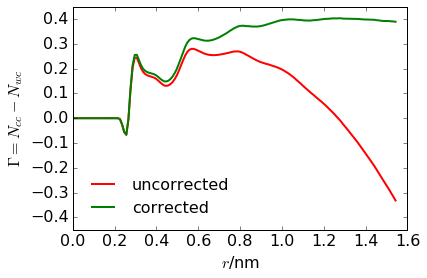

In [6]:
Vn = 4*pi/3*r**3 / volume
g_ccc = g_cc * N_c * (1-Vn) / ( N_c*(1-Vn)-N_cc-1)
g_wcc = g_wc * N_w * (1-Vn) / ( N_w*(1-Vn)-N_wc-0)
N_ccc  = rho_c * 4*pi*dr*np.cumsum( ( g_ccc - 1 )*r**2 )
N_wcc  = rho_c * 4*pi*dr*np.cumsum( ( g_wcc - 1 )*r**2 )
Gammac = N_ccc - N_wcc
plt.xlabel('$r$/nm')
plt.ylabel('$\\Gamma = N_{cc}-N_{wc}$')
plt.plot(r, Gamma, color='red', ls='-', lw=2, label='uncorrected')
plt.plot(r, Gammac, color='green', lw=2, label='corrected')
plt.legend(loc=0,frameon=False, fontsize=16)
plt.yticks( np.arange(-0.4, 0.5, 0.1))
plt.ylim((-0.45,0.45))
plt.savefig('gamma.pdf', bbox_inches='tight')